# D-Lab Blog Post 
Author: Emma Turtelboom


# Scrape a data set describing the most popular Halloween sweets

dataset: https://www.kaggle.com/datasets/fivethirtyeight/the-ultimate-halloween-candy-power-ranking/data

In [19]:
# Import useful packages
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import r2_score
import statsmodels.api as sm

In [41]:
# Let's read in the data
data = pd.read_csv('candy-data.csv')

## Data Exoplaration 

In [3]:
# What do the first few rows look like?
data.head()

competitorname  chocolate  fruity  caramel  peanutyalmondy  nougat  \
0      100 Grand          1       0        1               0       0   
1   3 Musketeers          1       0        0               0       1   
2       One dime          0       0        0               0       0   
3    One quarter          0       0        0               0       0   
4      Air Heads          0       1        0               0       0   

   crispedricewafer  hard  bar  pluribus  sugarpercent  pricepercent  \
0                 1     0    1         0         0.732         0.860   
1                 0     0    1         0         0.604         0.511   
2                 0     0    0         0         0.011         0.116   
3                 0     0    0         0         0.011         0.511   
4                 0     0    0         0         0.906         0.511   

   winpercent  
0   66.971725  
1   67.602936  
2   32.261086  
3   46.116505  
4   52.341465

In [4]:
#How many entries do we have?
data.shape

(85, 13)

In [5]:
# How many entries are missing?
data.isna().sum()

competitorname      0
chocolate           0
fruity              0
caramel             0
peanutyalmondy      0
nougat              0
crispedricewafer    0
hard                0
bar                 0
pluribus            0
sugarpercent        0
pricepercent        0
winpercent          0
dtype: int64

In [6]:
# What data types are the different columns?
data.dtypes

competitorname       object
chocolate             int64
fruity                int64
caramel               int64
peanutyalmondy        int64
nougat                int64
crispedricewafer      int64
hard                  int64
bar                   int64
pluribus              int64
sugarpercent        float64
pricepercent        float64
winpercent          float64
dtype: object

In [12]:
# Summary of the data frame
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85 entries, 52 to 44
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   competitorname    85 non-null     object 
 1   chocolate         85 non-null     int64  
 2   fruity            85 non-null     int64  
 3   caramel           85 non-null     int64  
 4   peanutyalmondy    85 non-null     int64  
 5   nougat            85 non-null     int64  
 6   crispedricewafer  85 non-null     int64  
 7   hard              85 non-null     int64  
 8   bar               85 non-null     int64  
 9   pluribus          85 non-null     int64  
 10  sugarpercent      85 non-null     float64
 11  pricepercent      85 non-null     float64
 12  winpercent        85 non-null     float64
dtypes: float64(3), int64(9), object(1)
memory usage: 9.3+ KB


## Let's plot the data set in order of popularity
Let's shade according to how sugary the candy is, since I'm curious if the most sugary sweets are the most popular?

In [16]:
cmap = mpl.colormaps['viridis']
norm = mpl.colors.Normalize(vmin=data.pricepercent.min(), vmax=data.sugarpercent.max())

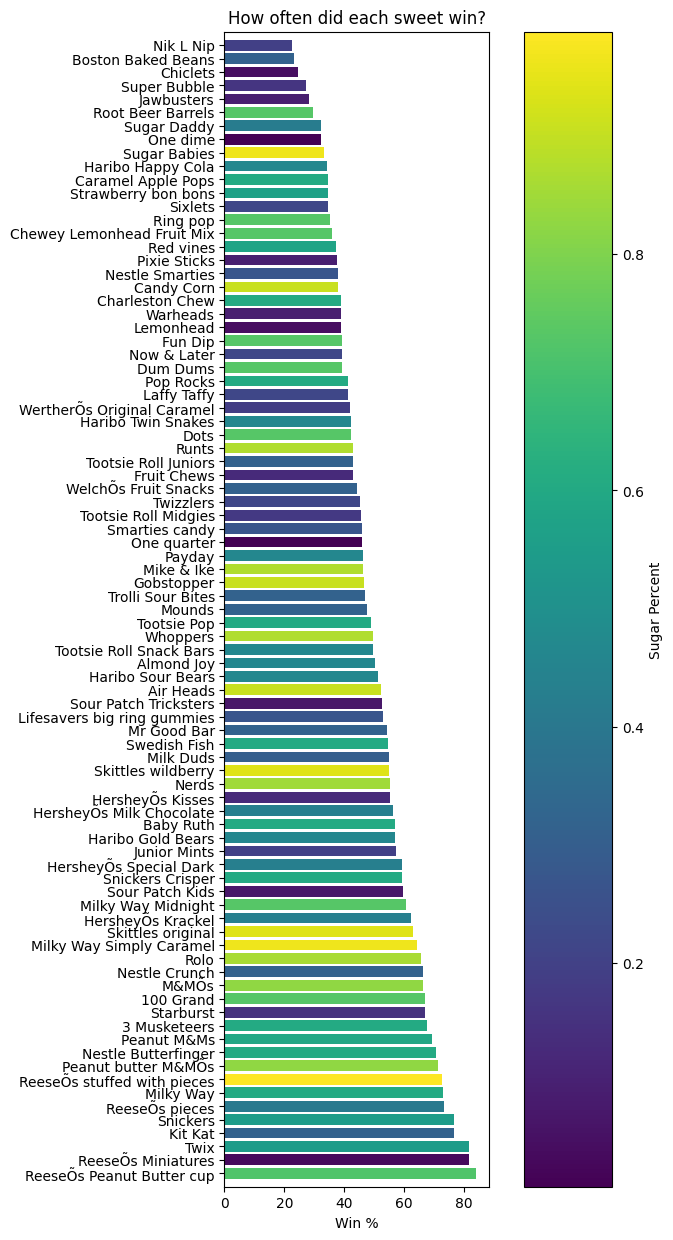

In [17]:
fig, axes = plt.subplots(1,2, figsize=(5,15), gridspec_kw={'width_ratios': [3, 1]})
ax, cax = axes[0], axes[1]
im = ax.barh(data.competitorname, data.winpercent, color=cmap(norm(data.sugarpercent)))
ax.set_xlabel('Win %')
ax.set_title('How often did each sweet win?')
ax.grid(False)
ax.set_ylim(-1, 85)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical', label='Sugar Percent')
plt.show()

Suprisingly, it seems like the most popular sweets are sugary, but not the most sugary!

## Plot correlations between columns

<Axes: >

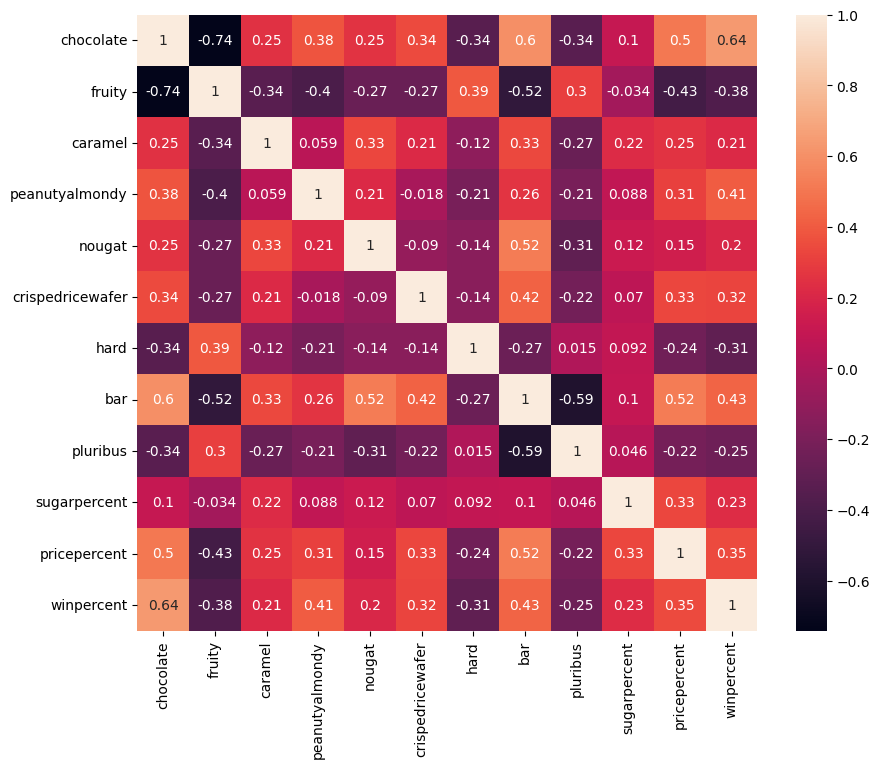

In [23]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(data.corr(), ax=ax, annot=True)

## Fitting a model to the data

In [42]:
# Make the winpercent column the same format as the pricepercent and sugarpercent columns
data.winpercent = data.winpercent / 100

In [47]:
#Split into training and test data
y = data.winpercent.to_numpy()
X = data[data.columns[1:-1]]
half = int(np.floor(len(y)/2))
train_X = X[:half]
train_y = y[:half]
test_X = X[half:]
test_y = y[half:]

In [48]:
# Add a constant intercept (Îµ) as an input variable to fit for
train_X = sm.add_constant(train_X)
# Create a generalized least squares model with our training data
model=sm.GLS(train_y, train_X)
# Fit the model
result=model.fit()

In [49]:
print (result.summary())

                            GLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.676
Model:                            GLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     5.683
Date:                Sat, 27 Jan 2024   Prob (F-statistic):           7.17e-05
Time:                        20:42:09   Log-Likelihood:                 49.493
No. Observations:                  42   AIC:                            -74.99
Df Residuals:                      30   BIC:                            -54.13
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.3248      0.054  

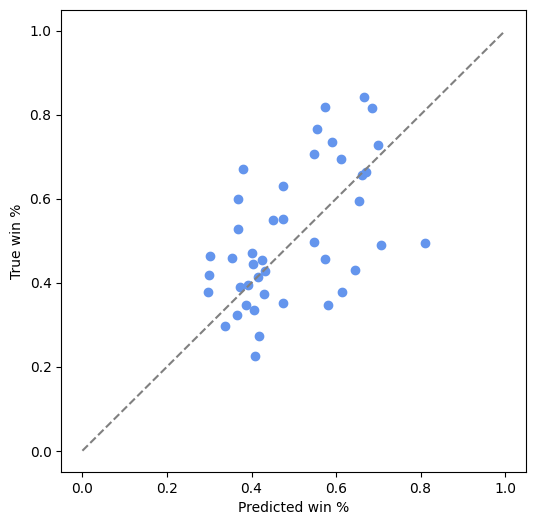

In [58]:
# use our model to predict y values given the test x values
predict_y = result.predict(sm.add_constant(test_X))

# plot the predicted y values against the true y values for the test set, and compare them to a straight line
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(predict_y, test_y, c='cornflowerblue')
ax.set_xlabel('Predicted win %')
ax.set_ylabel('True win %')
ax.plot(np.linspace(0,1), np.linspace(0,1), c='grey',linestyle='dashed')
plt.savefig('testmodel.png',dpi=200)

In [60]:
coefficient_of_dermination = r2_score(test_y, predict_y)

In [65]:
print ("R-squared for test data:", coefficient_of_dermination)

R-squared for test data: 0.2004411992885714


In [66]:
# Make an array with values for a new candy, including a constant and using the mean sugarpercent and pricepercent values
invent_X = [1.0, 1, 0, 1, 0, 0, 1, 1, 1, 1, data.sugarpercent.mean(), data.pricepercent.mean()]

# Now use our model to predict how popular this sweet would be
print (result.predict(invent_X))


[0.58800008]


In [69]:
# Make an array with values for the ideal candy
invent_X = [1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1]
# Now use our model to predict how popular this sweet would be
print (result.predict(invent_X))

[0.97397855]
